# Imports

In [3]:
import sys, os

from math import log10
from numpy import array, pi

import pandas as pd
import numpy as np
from numpy import concatenate
from bisect import bisect_left
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from hist import Hist
import hist

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import zero_one_loss, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.base import clone
# algorithms:
from sklearn.tree import export_graphviz, DecisionTreeClassifier#, plot_tree, export_text # Available in later versions
#import graphviz

# Setup plotting

In [10]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'family' : 'serif','weight' : 'normal','size'   : 22}
plt.rc('font', **font)

# Parameters

# Get data

In [7]:
df = pd.read_csv('tritium_ML_data.csv', index_col = 0)

df.head()

,runID,eventID,area,max_pulse_height,ext_elec,x,y,r,label,type,dt10_05,dt25_10,dt50_25,dt75_50,dt90_75,dt95_90
0,8136,65736,8888.486328,2.395982,188.835486,33.475193,-9.704426,34.853471,2,tritium,390.0,770.0,860.0,1110.0,940.0,750.0
1,8136,65820,3471.296631,2.344738,73.747538,-4.230170,-33.209011,33.477347,2,tritium,220.0,340.0,420.0,430.0,470.0,310.0
2,8136,66048,5252.145996,5.090684,111.581602,1.431782,-22.289442,22.335381,2,tritium,80.0,200.0,350.0,330.0,180.0,100.0
3,8136,66354,970.152954,0.417813,20.610855,-8.272943,-12.583660,15.059551,2,tritium,1130.0,1160.0,1080.0,960.0,1030.0,390.0
4,8155,20311,828.374695,0.801517,17.598783,5.756645,39.000084,39.422652,2,tritium,190.0,270.0,330.0,340.0,330.0,210.0


# Re-weight data

In [53]:
electron_axis = hist.axis.Regular(200,0.5,200.5,name="electrons",
                           label="Extracted electrons",flow=False)

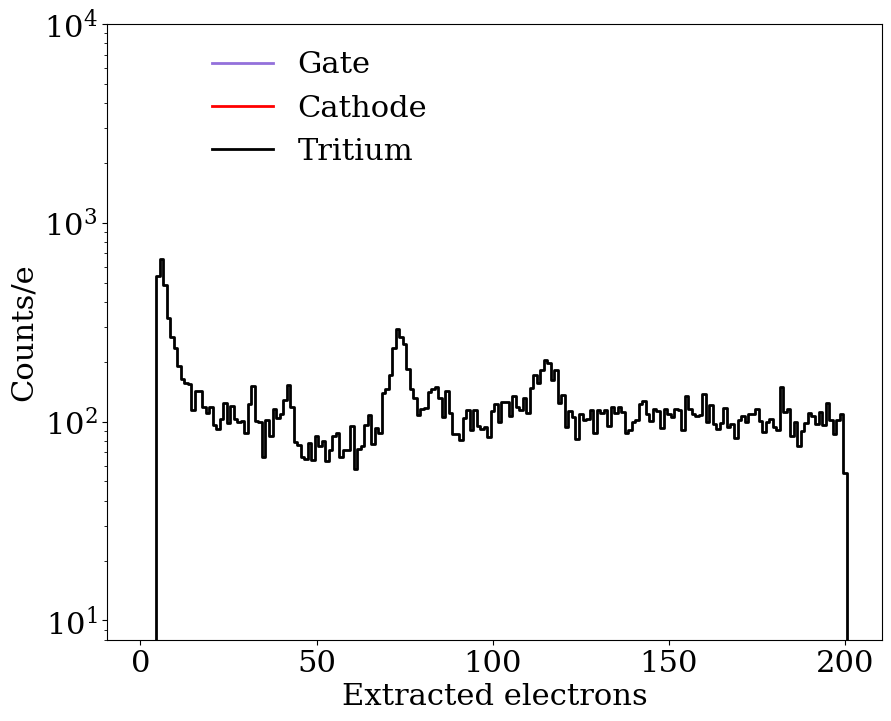

In [54]:
gate_hist = Hist(electron_axis)
gate_cut = df.type == "gate"
gate_hist.fill(df.ext_elec[gate_cut])

cath_hist = Hist(electron_axis)
cath_cut = df.type == "cath"
cath_hist.fill(df.ext_elec[cath_cut])

trit_hist = Hist(electron_axis)
trit_cut = df.type == "tritium"
trit_hist.fill(df.ext_elec[trit_cut])

fig, ax = plt.subplots(figsize=(10, 8))
gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)

ax.set(xlabel='Extracted electrons',ylabel='Counts/e',yscale='log',ylim=[8,10000])
ax.legend(bbox_to_anchor=(0.1,1),loc='upper left',frameon=False)

plt.show()

In [55]:
print(trit_hist.to_numpy()[1][50]) 
print(df.ext_elec[0])
print(trit_hist)

50.5
188.83548604472065
                   +---------------------------------------------------------+
[  0.5,   1.5) 0   |                                                         |
[  1.5,   2.5) 0   |                                                         |
[  2.5,   3.5) 0   |                                                         |
[  3.5,   4.5) 0   |                                                         |
[  4.5,   5.5) 539 |==============================================           |
[  5.5,   6.5) 656 |======================================================== |
[  6.5,   7.5) 487 |==========================================               |
[  7.5,   8.5) 332 |============================                             |
[  8.5,   9.5) 267 |=======================                                  |
[  9.5,  10.5) 235 |====================                                     |
[ 10.5,  11.5) 190 |================                                         |
[ 11.5,  12.5) 163 |========

In [57]:
weight_list = []

for ii in range(df.shape[0]):
    if df.type[ii] == 'gate':
        index = np.searchsorted(gate_hist.to_numpy()[1],df.ext_elec[ii]) - 1
        bin_counts = gate_hist[index]
    elif df.type[ii] == 'cath':
        index = np.searchsorted(cath_hist.to_numpy()[1],df.ext_elec[ii]) - 1
        bin_counts = cath_hist[index]
    elif df.type[ii] == 'tritium':
        index = np.searchsorted(trit_hist.to_numpy()[1],df.ext_elec[ii]) - 1
        bin_counts = trit_hist[index] 
    weight_list.append(1/bin_counts)

        
df['weights'] = weight_list

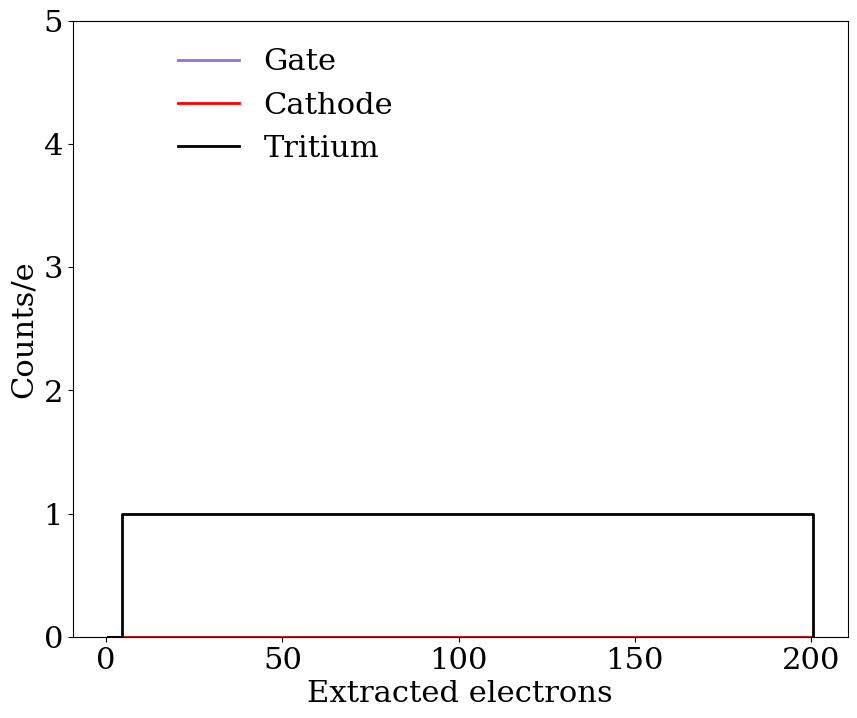

In [58]:
norm_gate_hist = Hist(electron_axis)
gate_cut = df.type == "gate"
norm_gate_hist.fill(df.ext_elec[gate_cut],weight = df.weights[gate_cut])

norm_cath_hist = Hist(electron_axis)
cath_cut = df.type == "cath"
norm_cath_hist.fill(df.ext_elec[cath_cut],weight = df.weights[cath_cut])

norm_trit_hist = Hist(electron_axis)
trit_cut = df.type == "tritium"
norm_trit_hist.fill(df.ext_elec[trit_cut],weight = df.weights[trit_cut])

fig, ax = plt.subplots(figsize=(10, 8))
norm_gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
norm_cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
norm_trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)

ax.set(xlabel='Extracted electrons',ylabel='Counts/e',ylim=[0,5])
ax.legend(bbox_to_anchor=(0.1,1),loc='upper left',frameon=False)

plt.show()

# Machine learning

### Prepare data for machine learning

In [28]:
df_ML = df[df.ext_elec > ana_thresh_e]#.loc[:,features]
df_ML.head()

,label,type,weight,luxstamp,time_since_1e5_phe,S1_spiky,S1_spiky_cor,area,area_cor,spiky,...,dt05_01,dt10_05,dt25_10,dt50_25,dt75_50,dt90_75,dt95_90,dt99_95,ext_elec,weights
0,1,gate,0.000967,7288872996049035,64414764,2.0,2.252349,804.234314,891.930420,705.0,...,18.0,19.0,30.0,36.0,56.0,58.0,26.0,41.0,32.825890,0.045455
1,1,gate,0.001013,7288941777834926,82496144,2.0,2.596129,820.775574,896.044250,723.0,...,27.0,16.0,29.0,37.0,42.0,37.0,23.0,54.0,33.501044,0.047619
2,1,gate,0.001637,7289702920133704,87490112,3.0,3.716992,645.691406,747.300171,571.0,...,14.0,13.0,20.0,26.0,27.0,26.0,13.0,30.0,26.354751,0.076923
3,1,gate,0.000327,7290004788853087,84500976,55.0,88.603195,144.175491,178.301743,142.0,...,21.0,68.0,26.0,21.0,32.0,56.0,12.0,13.0,5.884714,0.015385
4,1,gate,0.000967,7290125390757952,153123904,19.0,30.082190,418.659210,520.163574,361.0,...,22.0,14.0,22.0,30.0,37.0,41.0,20.0,32.0,17.088131,0.045455


In [29]:
features = ['max_pulse_height','pulse_height_phe_per_sample', 'dt05_01',
       'dt10_05', 'dt25_10', 'dt50_25', 'dt75_50', 'dt90_75', 'dt95_90',
       'dt99_95','hft_t0_samples', 'hft_t1_samples', 'hft_t2_samples', 'ext_elec']

X = df_ML[features]
Y = df_ML['label']
T = df_ML['type']
W = df_ML['weight']
A = df_ML['area']
R = df_ML['r_raw']
X_raw = df_ML['x_raw']
Y_raw = df_ML['y_raw']
L = df_ML['luxstamp']
X_train_unscaled, X_test_unscaled, \
Y_train, Y_test, \
W_train, W_test, \
A_train, A_test, \
T_train, T_test, \
R_train, R_test, \
X_raw_train, X_raw_test, \
Y_raw_train, Y_raw_test, \
L_train, L_test = \
train_test_split(X, Y, W, A, T, R, X_raw, Y_raw, L, random_state=0)

In [30]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_unscaled.astype('float64'))
X_test = scaler.transform(X_test_unscaled.astype('float64'))

### Adaptively boosted decision tree

In [31]:
DTC = DecisionTreeClassifier(max_depth=2,min_samples_split=2)
ABC = AdaBoostClassifier(base_estimator=DTC,n_estimators=100,algorithm = 'SAMME')
model = ABC.fit(X_train, Y_train.values.ravel()
                ,sample_weight=W_train.values.ravel().astype('float64'))

Y_score = model.decision_function(X_test)

model.score(X_train, Y_train, sample_weight=W_train.astype('float64')), \
model.score(X_test, Y_test, sample_weight=W_test.astype('float64')) 

/Users/kcoliver-mallory/opt/anaconda3/envs/py3root6/lib/python3.8/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


(0.7602026071409557, 0.727554241808811)

# Understanding machine learning

# Results

In [34]:
FPR, TPR, TH = roc_curve(Y_test,Y_score,sample_weight = W_test,pos_label = 2)

In [36]:
TH

array([ 1.36580598,  0.36580598,  0.36498562, ..., -0.48858213,
       -0.49896286, -0.57475917])

In [37]:
TPR

array([0.00000000e+00, 9.49816266e-05, 2.14980256e-03, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [38]:
Y_score

array([-0.14371921,  0.18322061,  0.05441131, ..., -0.05872135,
        0.1343712 , -0.07522485])